In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd
import os

In [2]:
exp_dir = "/workspace/CSDI/save/gaussian_noise_im_ddim_eta0.0_imutation/physio_fold0_missing10p_20231207_074206"

In [3]:
dataset = 'healthcare' #choose 'healthcare' or 'airquality'

with open(os.path.join(exp_dir, "generated_outputs_nsample100.pk"), 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length
print(f"sample shape={samples.shape}, K={K}, L={L}")

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    train_std_cuda = torch.from_numpy(train_std).cuda()
    train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)
    
print(f"target. max:{all_target_np[3,:,0].max()}, min:{all_target_np[3,:,0].min()}")
print(f"samples. max:{samples[3,:,0].max()}, min:{samples[3,:,0].min()}")
print(f"all_evalpoint_np. max:{all_evalpoint_np[3,:,0].max()}, min:{all_evalpoint_np[3,:,0].min()}")
print(f"all_observed_np. max:{all_observed_np[3,:,0].max()}, min:{all_observed_np[3,:,0].min()}")
print(f"all_given_np. max:{all_given_np[3,:,0].max()}, min:{all_given_np[3,:,0].min()}")


sample shape=torch.Size([799, 100, 48, 35]), K=35, L=48
target. max:1.2646809816360474, min:-0.1184057667851448
samples. max:2.974621057510376, min:-2.6173667907714844
all_evalpoint_np. max:1.0, min:0.0
all_observed_np. max:1.0, min:0.0
all_given_np. max:1.0, min:0.0


In [4]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

qlist =[0.05,0.25,0.5,0.75,0.95]
# qlist =[0.4,0.45,0.5,0.55,0.6]
quantiles_imp= []
print("quantiles_imp")
for q in qlist:
    quantile_imp = get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np
    print(f"max:{quantile_imp[3,:,0].max()}, min:{quantile_imp[3,:,0].min()}")
    quantiles_imp.append(quantile_imp)
    
# print(f"quantile_imp shape={quantiles_imp[0].shape}. max:{quantiles_imp[0][3,:,0].max()}, min:{quantiles_imp[0][3,:,0].min()}")


quantiles_imp
max:1.2646809816360474, min:-1.1072192192077637
max:1.2646809816360474, min:-0.42591848969459534
max:1.2646809816360474, min:-0.1184057667851448
max:1.2646809816360474, min:-0.1184057667851448
max:1.2646809816360474, min:-0.1184057667851448


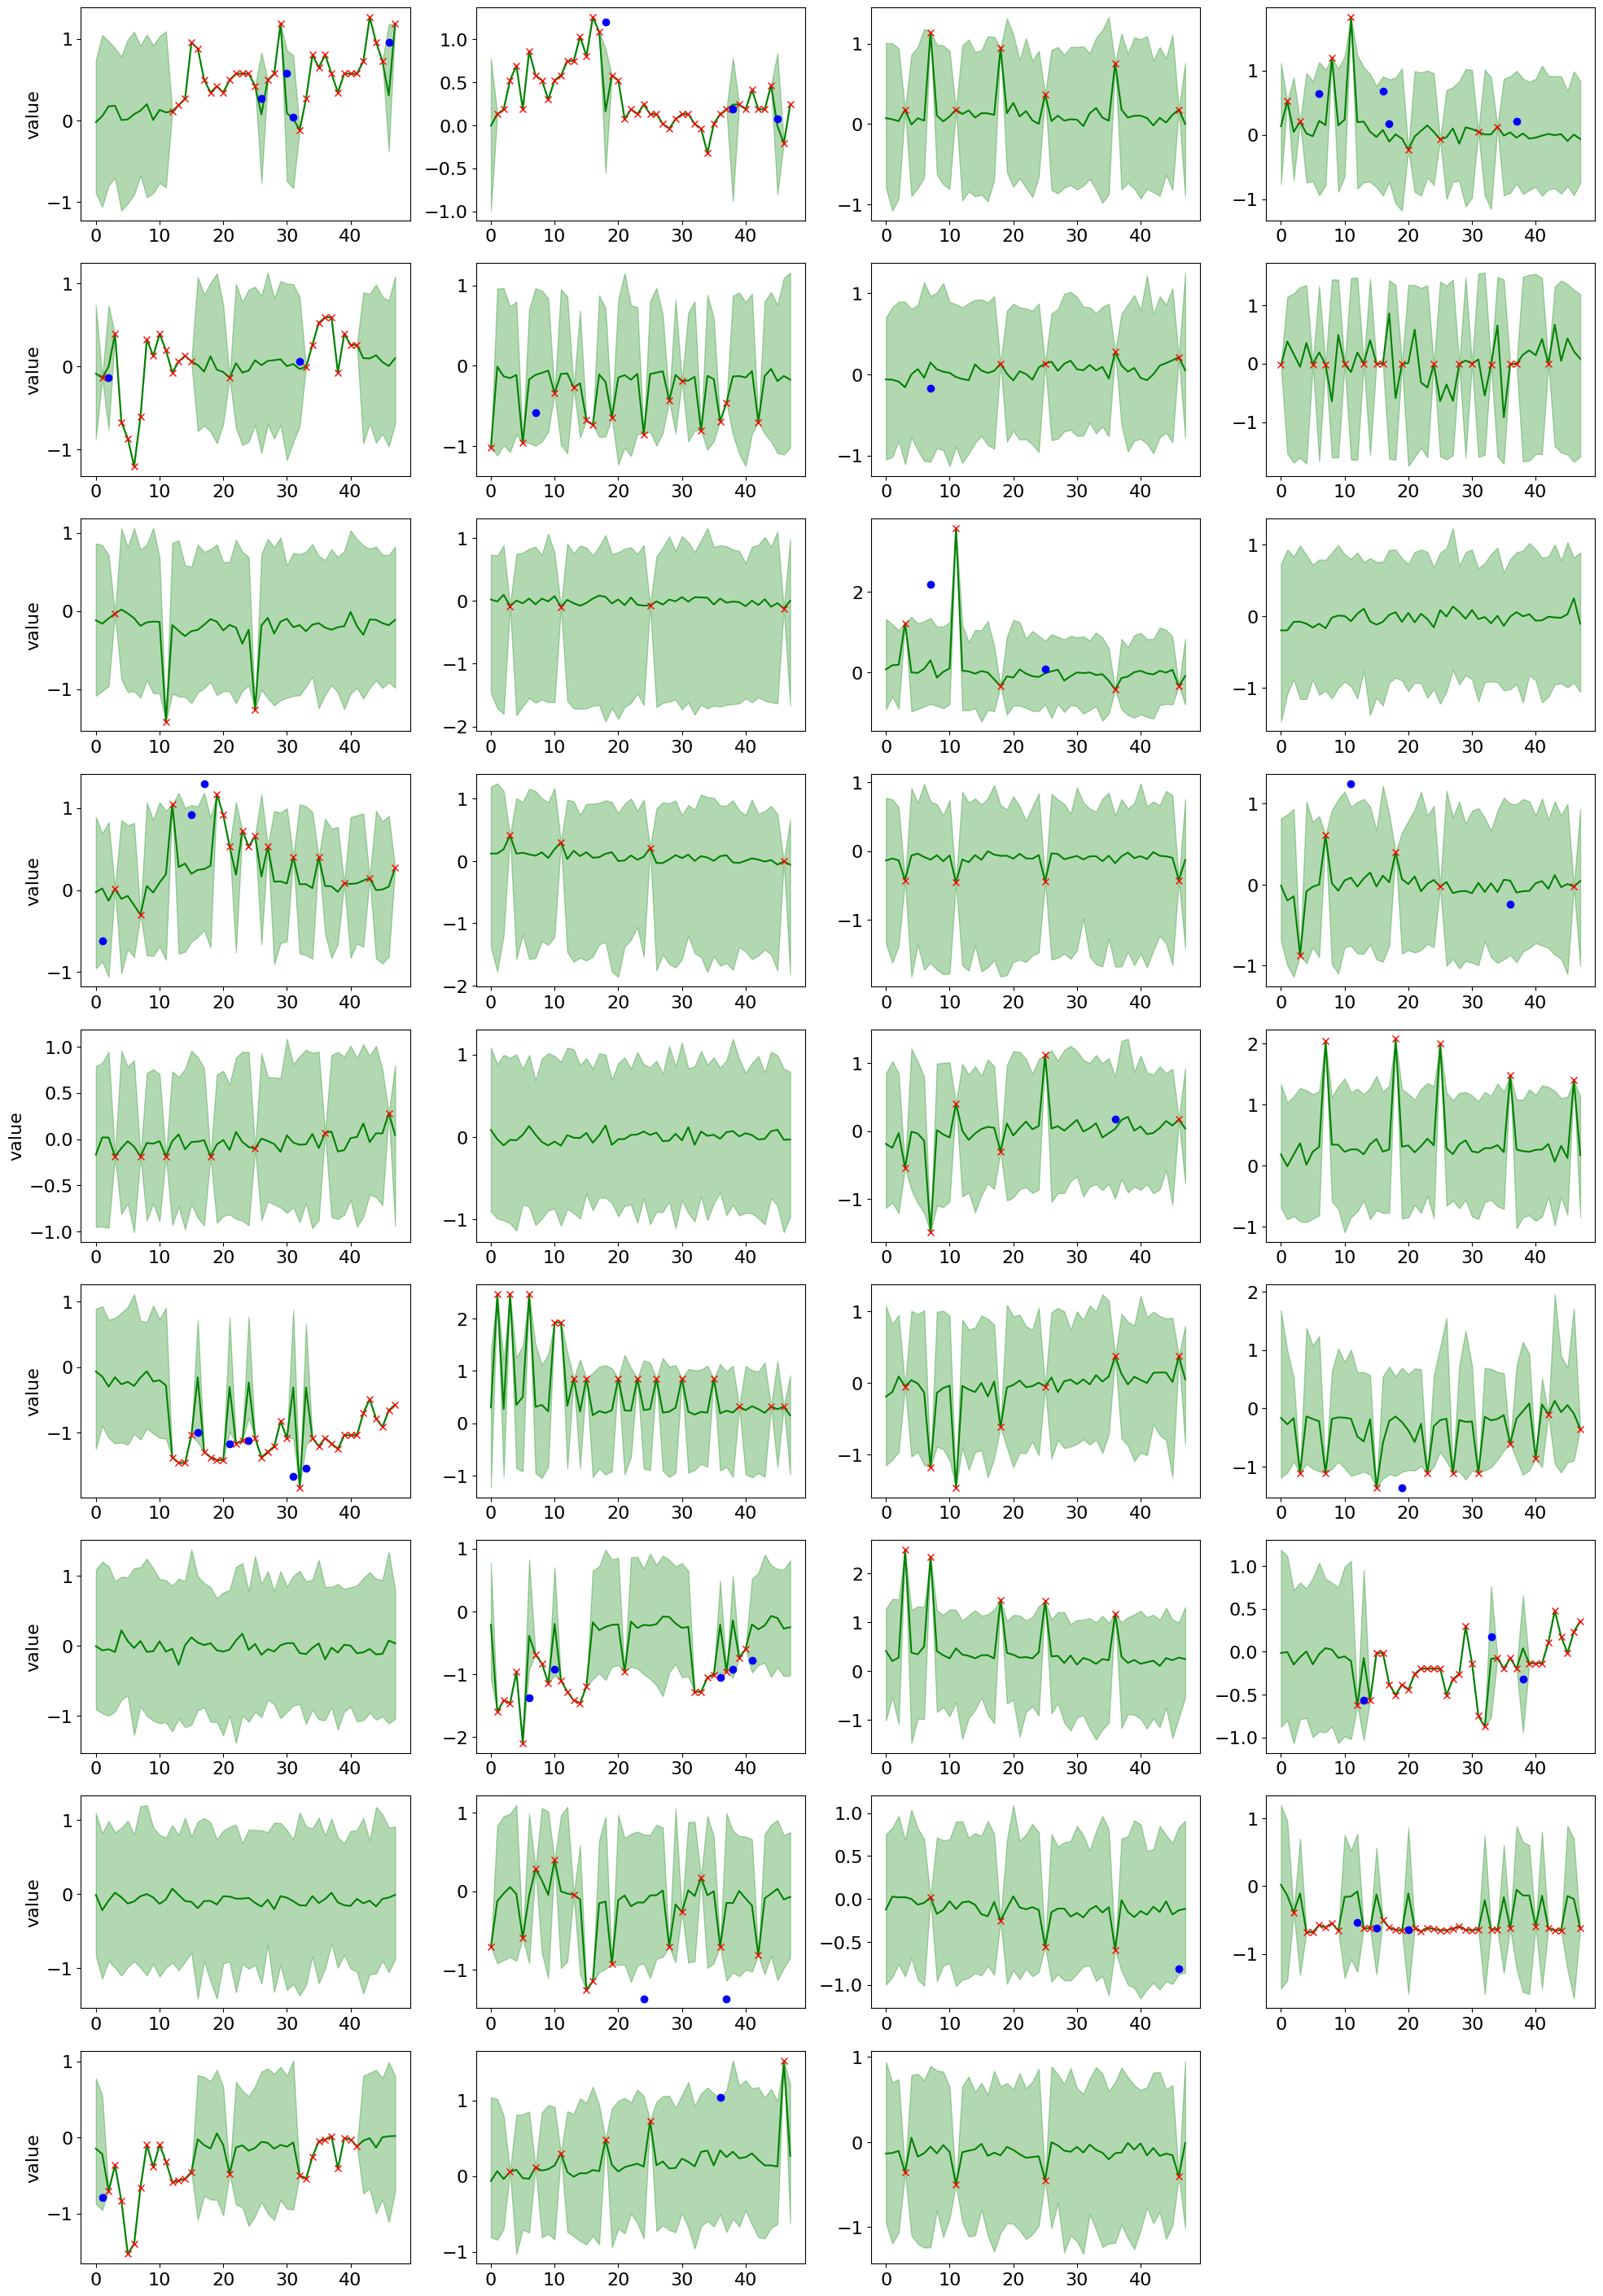

In [5]:
###healthcare###
dataind = 3 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[int(len(quantiles_imp)/2)][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[-1][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


In [7]:
### metric ###
with open(os.path.join(exp_dir, "result_nsample100.pk"), 'rb') as f:
    RMSE, MAE, CRPS = pickle.load( f)

print(f"evaluate.RMSE:" + str(RMSE))
print(f"evaluate.MAE:" + str(MAE))
print("evaluate.CRPS:" + str(CRPS))



evaluate.RMSE:0.9100155884361574
evaluate.MAE:0.6057310311287556
evaluate.CRPS:0.671260632966694
